In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('kenya_tripadvisor_data_1.csv')
df1.head()

,Destination Name,Destination Type,Rating,Review Head,Review Body,Date
0,Giraffe Centre,Nature/Parks,5,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,June 2017
1,Giraffe Centre,Nature/Parks,4,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,December 2016
2,Giraffe Centre,Nature/Parks,3,Close to the giraffes,You get to come very close to the giraffes. Yo...,June 2017
3,Giraffe Centre,Nature/Parks,5,Giraffe kiss!,If you like giraffes you'll love this place. E...,June 2017
4,Giraffe Centre,Nature/Parks,5,A wonderful moment in time.,We always visit this attraction each and every...,June 2017


In [3]:
df2 = df1.copy()
df2.head()

,Destination Name,Destination Type,Rating,Review Head,Review Body,Date
0,Giraffe Centre,Nature/Parks,5,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,June 2017
1,Giraffe Centre,Nature/Parks,4,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,December 2016
2,Giraffe Centre,Nature/Parks,3,Close to the giraffes,You get to come very close to the giraffes. Yo...,June 2017
3,Giraffe Centre,Nature/Parks,5,Giraffe kiss!,If you like giraffes you'll love this place. E...,June 2017
4,Giraffe Centre,Nature/Parks,5,A wonderful moment in time.,We always visit this attraction each and every...,June 2017


In [4]:
from nltk import tokenize

df2.drop('Rating', axis = 1, inplace = True)
df2.drop('Date', axis = 1, inplace = True)
df2['Review Head'] = df2['Review Head'].apply(lambda x: re.sub('\s+', ' ', x))
df2['Review Body'] = df2['Review Body'].apply(lambda x: re.sub('\s+', ' ', x))
df2['RB_Sentence1'] = df2['Review Body'].apply(lambda x: tokenize.sent_tokenize(x)[0])
df2['RH_Split'] = df2['Review Head'].apply(lambda x: x.split(' '))
df2['RB_Split'] = df2['Review Body'].apply(lambda x: x.split(' '))
df2['RB_Sentence1_Split'] = df2['RB_Sentence1'].apply(lambda x: x.split(' '))
df2['TextBlob Polarity Head'] = df2['Review Head'].map(lambda text: TextBlob(text).sentiment.polarity)
df2['TextBlob Polarity Body'] = df2['Review Body'].map(lambda text: TextBlob(text).sentiment.polarity)
df2['TextBlob Polarity RBS1'] = df2['RB_Sentence1'].map(lambda text: TextBlob(text).sentiment.polarity)

In [5]:
df2.head()

,Destination Name,Destination Type,Review Head,Review Body,RB_Sentence1,RH_Split,RB_Split,RB_Sentence1_Split,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity RBS1
0,Giraffe Centre,Nature/Parks,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,If you find yourself with a day in Nairobi bef...,"[Giraffes, and, Baby, Elephants!]","[If, you, find, yourself, with, a, day, in, Na...","[If, you, find, yourself, with, a, day, in, Na...",0.0,0.160000,0.16
1,Giraffe Centre,Nature/Parks,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,A fun place to visit - you not only get to fee...,"[Places, to, visit, in, Karen, -, Giraffe, Cen...","[A, fun, place, to, visit, -, you, not, only, ...","[A, fun, place, to, visit, -, you, not, only, ...",0.0,0.450000,0.15
2,Giraffe Centre,Nature/Parks,Close to the giraffes,You get to come very close to the giraffes. Yo...,You get to come very close to the giraffes.,"[Close, to, the, giraffes]","[You, get, to, come, very, close, to, the, gir...","[You, get, to, come, very, close, to, the, gir...",0.0,0.100000,0.20
3,Giraffe Centre,Nature/Parks,Giraffe kiss!,If you like giraffes you'll love this place. E...,If you like giraffes you'll love this place.,"[Giraffe, kiss!]","[If, you, like, giraffes, you'll, love, this, ...","[If, you, like, giraffes, you'll, love, this, ...",0.0,0.200000,0.50
4,Giraffe Centre,Nature/Parks,A wonderful moment in time.,We always visit this attraction each and every...,We always visit this attraction each and every...,"[A, wonderful, moment, in, time.]","[We, always, visit, this, attraction, each, an...","[We, always, visit, this, attraction, each, an...",1.0,0.214286,0.00


In [6]:
df2['Destination Type'].value_counts()

Nature/Parks    21143
Museums          4685
Landmarks        3307
Name: Destination Type, dtype: int64

### Topic Modelling

In [7]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df2['RH_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list))

Positive : 16736
Neutral : 112476
Negative : 618


In [8]:
from nltk.corpus import stopwords

# main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
#                        'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
#                        'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
#                        'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
#                        '\n', '‘s']

main_stop_words = ['kenya', 'kenyan', 'africa', 'african', 'church', 'churches', 'park', 'parks', 'museum', 'museums',
                   'lamu', 'valley', 'mountain', 'mountains', 'national', 'nairobi', 'amboseli'  
                   'cathedral', 'cathedrals', 'place', 'visit', 'site', 'town',  
                   '\n', '‘s']

positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  1493


In [9]:
# Convert to list
data = df2[df2['Destination Type'] == 'Museums'][df2['TextBlob Polarity Head'] < 0]['Review Head'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Big engines in small museum']


In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['big', 'engines', 'in', 'small', 'museum']]


In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['big', 'engines', 'in', 'small', 'museum']


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['big', 'engine', 'small']]


In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('big', 1), ('engine', 1), ('small', 1)]]

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.149*"small" + 0.080*"gem" + 0.058*"time" + 0.049*"average" + 0.035*"hide" '
  '+ 0.034*"informative" + 0.034*"long" + 0.032*"expensive" + 0.026*"get" + '
  '0.024*"treasure"'),
 (1,
  '0.107*"spend" + 0.055*"well" + 0.055*"sure" + 0.045*"hour" + '
  '0.042*"history" + 0.038*"small" + 0.032*"ever" + 0.032*"maintain" + '
  '0.030*"big" + 0.023*"plan"'),
 (2,
  '0.116*"history" + 0.059*"lane" + 0.059*"consider" + 0.046*"quite" + '
  '0.046*"memory" + 0.041*"art" + 0.024*"carefully" + 0.024*"punch" + '
  '0.024*"stamp" + 0.024*"pack"'),
 (3,
  '0.150*"bore" + 0.086*"expensive" + 0.046*"culture" + 0.029*"lot" + '
  '0.026*"small" + 0.025*"building" + 0.024*"people" + 0.024*"variety" + '
  '0.017*"eat" + 0.017*"non"'),
 (4,
  '0.107*"money" + 0.078*"walk" + 0.054*"foreigner" + 0.043*"price" + '
  '0.043*"value" + 0.029*"usual" + 0.027*"house" + 0.022*"collection" + '
  '0.022*"step" + 0.016*"excessive"'),
 (5,
  '0.054*"really" + 0.051*"hard" + 0.041*"take" + 0.041*"slow" + '
  '0.

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.649920459251129

Coherence Score:  0.5702467268982301


In [19]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [20]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, random_seed=1)

In [21]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('exhibit', 0.0975609756097561),
   ('small', 0.07317073170731707),
   ('building', 0.07317073170731707),
   ('historical', 0.07317073170731707),
   ('step', 0.04878048780487805),
   ('thing', 0.04878048780487805),
   ('people', 0.024390243902439025),
   ('part', 0.024390243902439025),
   ('authentic', 0.024390243902439025),
   ('preserve', 0.024390243902439025)]),
 (1,
  [('expensive', 0.14285714285714285),
   ('hide', 0.14285714285714285),
   ('informative', 0.11428571428571428),
   ('painting', 0.05714285714285714),
   ('hidden', 0.02857142857142857),
   ('worthwhile', 0.02857142857142857),
   ('hustle', 0.02857142857142857),
   ('year', 0.02857142857142857),
   ('fairly', 0.02857142857142857),
   ('back', 0.02857142857142857)]),
 (2,
  [('worth', 0.17777777777777778),
   ('money', 0.1111111111111111),
   ('gem', 0.08888888888888889),
   ('treasure', 0.06666666666666667),
   ('tour', 0.06666666666666667),
   ('wall', 0.044444444444444446),
   ('slow', 0.044444444444444446),


2
3
4
5
6
7
8
9
10


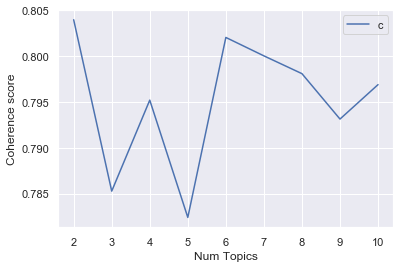

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word,
                                                random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.804
Num Topics = 3  has Coherence Value of 0.7853
Num Topics = 4  has Coherence Value of 0.7952
Num Topics = 5  has Coherence Value of 0.7824
Num Topics = 6  has Coherence Value of 0.8021
Num Topics = 7  has Coherence Value of 0.8
Num Topics = 8  has Coherence Value of 0.7981
Num Topics = 9  has Coherence Value of 0.7931
Num Topics = 10  has Coherence Value of 0.7969


In [32]:
optimal_model = model_list[4] # Number of Topics = 6

# optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=7, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.304*"small" + 0.063*"lot" + 0.051*"culture" + 0.051*"boring" + '
  '0.051*"hour" + 0.038*"tour" + 0.025*"steam" + 0.025*"fan" + 0.013*"poorly" '
  '+ 0.013*"attention"'),
 (1,
  '0.203*"expensive" + 0.094*"average" + 0.047*"historical" + 0.047*"treasure" '
  '+ 0.031*"trip" + 0.031*"bit" + 0.031*"gallery" + 0.016*"karen" + '
  '0.016*"fairly" + 0.016*"decent"'),
 (2,
  '0.115*"gem" + 0.092*"worth" + 0.057*"bit" + 0.057*"hide" + 0.046*"exhibit" '
  '+ 0.046*"long" + 0.046*"past" + 0.034*"art" + 0.034*"big" + '
  '0.011*"location"'),
 (3,
  '0.132*"bore" + 0.088*"past" + 0.059*"blast" + 0.044*"lane" + 0.029*"step" + '
  '0.029*"people" + 0.015*"mediocre" + 0.015*"foreigner" + 0.015*"random" + '
  '0.015*"restaurant"'),
 (4,
  '0.106*"spend" + 0.076*"bore" + 0.076*"walk" + 0.045*"collection" + '
  '0.045*"thing" + 0.030*"memory" + 0.030*"slow" + 0.030*"foreigner" + '
  '0.030*"overprice" + 0.030*"make"'),
 (5,
  '0.221*"history" + 0.070*"time" + 0.058*"money" + 0.047*"hard" + '


In [33]:
optimal_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.260559 -0.225688       1        1  16.846409
2     -0.001251  0.321347       2        1  16.745714
0     -0.266087 -0.007307       3        1  16.689088
4      0.267038 -0.174154       4        1  16.647016
3      0.208264 -0.117906       5        1  16.579994
1      0.052595  0.203709       6        1  16.491779, topic_info=    Category       Freq         Term      Total  loglift  logprob
2    Default  28.000000        small  28.000000  30.0000  30.0000
60   Default  20.000000      history  20.000000  29.0000  29.0000
12   Default  18.000000    expensive  18.000000  28.0000  28.0000
49   Default  19.000000         bore  19.000000  27.0000  27.0000
72   Default  10.000000          gem  10.000000  26.0000  26.0000
36   Default   9.000000        spend   9.000000  25.0000  25.0000
37   Default   8.000000      average   8.000000  24.0000  24.0000
70   Default   8.000000        worth   8.000000  23.0000  23.0000
54   Default  12.000000         past  12.000000  22.0000  22.0000
32   Default   7.000000         walk   7.000000  21.0000  21.0000
41   Default   6.000000         time   6.000000  20.0000  20.0000
42   Default   5.000000          lot   5.000000  19.0000  19.0000
99   Default   5.000000        blast   5.000000  18.0000  18.0000
119  Default   5.000000        money   5.000000  17.0000  17.0000
73   Default   5.000000         hide   5.000000  16.0000  16.0000
19   Default   8.000000          bit   8.000000  15.0000  15.0000
44   Default   4.000000      culture   4.000000  14.0000  14.0000
256  Default   4.000000         hour   4.000000  13.0000  13.0000
31   Default   4.000000  informative   4.000000  12.0000  12.0000
133  Default   4.000000         hard   4.000000  11.0000  11.0000
175  Default   4.000000     treasure   4.000000  10.0000  10.0000
21   Default   4.000000   historical   4.000000   9.0000   9.0000
40   Default   4.000000         long   4.000000   8.0000   8.0000
86   Default   4.000000      exhibit   4.000000   7.0000   7.0000
20   Default   5.000000       boring   5.000000   6.0000   6.0000
24   Default   4.000000        thing   4.000000   5.0000   5.0000
26   Default   4.000000   collection   4.000000   4.0000   4.0000
165  Default   4.000000         lane   4.000000   3.0000   3.0000
7    Default   3.000000         tour   3.000000   2.0000   2.0000
48   Default   3.000000         wide   3.000000   1.0000   1.0000
..       ...        ...          ...        ...      ...      ...
106   Topic6   1.450761         junk   1.450761   1.8023  -4.1589
68    Topic6   1.450761       secret   1.450761   1.8023  -4.1589
166   Topic6   2.901522      gallery   2.901522   1.8023  -3.4657
66    Topic6   1.450761       decent   1.450761   1.8023  -4.1589
58    Topic6   1.450761       fairly   1.450761   1.8023  -4.1589
47    Topic6   1.450761      content   1.450761   1.8023  -4.1589
37    Topic6   8.704567      average   8.704567   1.8023  -2.3671
21    Topic6   4.352284   historical   4.352284   1.8023  -3.0603
12    Topic6  18.859895    expensive  18.859895   1.8023  -1.5939
159   Topic6   1.450761      adamson   1.450761   1.8023  -4.1589
144   Topic6   1.450761        karen   1.450761   1.8023  -4.1589
10    Topic6   1.450761     evidence   1.450761   1.8023  -4.1589
225   Topic6   2.901522         trip   2.901522   1.8023  -3.4657
172   Topic6   1.450761         area   1.450761   1.8023  -4.1589
174   Topic6   1.450761      walking   1.450761   1.8023  -4.1589
267   Topic6   1.450761   tumbledown   1.450761   1.8023  -4.1589
175   Topic6   4.352284     treasure   4.352284   1.8023  -3.0603
182   Topic6   1.450761      weekend   1.450761   1.8023  -4.1589
194   Topic6   1.450761        leave   1.450761   1.8023  -4.1589
195   Topic6   1.450761    pointless   1.450761   1.8023  -4.1589
266   Topic6   1.450761      shallow   1.450761   1.8023  -4.1589
257   Topic6   1.450761    

In [34]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.1782,"gem, worth, bit, hide, exhibit, long, past, ar...",Big engines in small museum
1,1,0.0,0.1987,"small, lot, culture, boring, hour, tour, steam...",A Poor Advocate for Science and Reason
2,2,2.0,0.1887,"gem, worth, bit, hide, exhibit, long, past, ar...",Intresting half day tour
3,3,1.0,0.1795,"expensive, average, historical, treasure, trip...",Not enough evidence of what they say a bout th...
4,4,1.0,0.1830,"expensive, average, historical, treasure, trip...",Expensive for what you get
5,5,0.0,0.1667,"small, lot, culture, boring, hour, tour, steam...",Not much else to see so might as well go there
6,6,0.0,0.1667,"small, lot, culture, boring, hour, tour, steam...",Pathetic restrunt service
7,7,2.0,0.1795,"gem, worth, bit, hide, exhibit, long, past, ar...",A bit boring
8,8,0.0,0.1795,"small, lot, culture, boring, hour, tour, steam...",A very historical place but sadly not much inside
9,9,4.0,0.1830,"spend, bore, walk, collection, thing, memory, ...",to see because there are few things to see oth...


In [35]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    111
2.0     40
3.0     37
1.0     35
5.0     29
4.0     24
Name: Dominant_Topic, dtype: int64

In [36]:
df_dominant_topic.to_csv('kenya_462.csv', index = False)

In [49]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# Run 2

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Lack of Content - 111
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Expensive Fees - 35
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Topicless/Unidentifiable - 40
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Lack of Content - 37
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Topicless/Unidentifiable - 24
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Lack of Content - 29

In [50]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# Run 1

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Expressing Disappointment - 91
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Food Criticism - 31
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Accessibility Criticism - 19
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # General Criticism - 18
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Maintenance Criticism - 21
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # General Criticism - 24
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # General Criticism - 16

In [51]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1987,"small, lot, culture, boring, hour, tour, steam...",A Poor Advocate for Science and Reason
1,1.0,0.1950,"expensive, average, historical, treasure, trip...",Very Long Dance Show
2,2.0,0.2099,"gem, worth, bit, hide, exhibit, long, past, ar...",The ancient ruins of a village that existed on...
3,3.0,0.1973,"bore, past, blast, lane, step, people, mediocr...",A hidden restaurant behind Wilson Airport for ...
4,4.0,0.1977,"spend, bore, walk, collection, thing, memory, ...",boring... boring.. the only thing worth watchi...
5,5.0,0.1987,"history, time, money, hard, informative, wide,...",Not a good value of time & money


In [52]:
sent_topics_sorteddf_mallet['Text'].values

array(['A Poor Advocate for Science and Reason', 'Very Long Dance Show',
       'The ancient ruins of a village that existed on the northern coast of Mombasa, Kenya.',
       'A hidden restaurant behind Wilson Airport for people seeking a fresh meal in an intimate setting',
       'boring... boring.. the only thing worth watching was the River birds.. building their nest..',
       'Not a good value of time & money'], dtype=object)

In [53]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics